In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import cv2
import numpy as np
import zipfile
from sklearn.metrics.pairwise import euclidean_distances
import umap
import matplotlib.pyplot as plt

## 1- Restructured Encoder, Decoder, and VAE

In [27]:

def build_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
    return Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


def build_decoder(latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 128, activation='relu')(decoder_inputs)
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return Model(decoder_inputs, decoder_outputs, name="decoder")


class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)




## 2- rebuild the model, dummy input to rebuild the model, and load the weights

In [28]:

latent_dim = 32
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)


dummy_input = tf.random.normal((1, 128, 128, 3))
_ = vae(dummy_input)


vae.load_weights('vae_final.weights.h5')

print("Load the weights for model")

Load the weights for model


## 3- Prepared paths of train data to preprocess and to git the laten space vector 

In [29]:
def open_zip(zip_path,extract_folder):
  # فك الضغط
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_folder)

  print("✅ تم فك الضغط بنجاح!")


In [32]:
open_zip('data_split_pants.zip','data_split_pants')

✅ تم فك الضغط بنجاح!


In [33]:
open_zip('data_split_top.zip','data_split_top')

✅ تم فك الضغط بنجاح!


In [34]:
pants_train_folder = 'data_split_pants/data_split_pants/train'    
tops_train_folder = 'data_split_top/data_split_top/train'     

## 4- Preprocess train data

In [35]:
def load_and_preprocess_images(folder_path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                img = img.astype('float32') / 255.0  # Normalization
                images.append(img)
    return np.array(images)


pants_train_images = load_and_preprocess_images(pants_train_folder)
tops_train_images = load_and_preprocess_images(tops_train_folder)


print(f"👖 Pants trained images:", pants_train_images.shape)
print(f"👕 Tops trained images:", tops_train_images.shape)



👖 Pants trained images: (6565, 128, 128, 3)
👕 Tops trained images: (8116, 128, 128, 3)


## 5- Merge Tops and Pants Train data

In [36]:

train_images = np.concatenate([pants_train_images, tops_train_images], axis=0)

# طباعة شكل البيانات الجديد
print(f"📦 Merge Data:", train_images.shape)

📦 Merge Data: (14681, 128, 128, 3)


## 6- Prepared paths if we want to predict then we print it

In [37]:
def git_the_path_in_list(folder,paths):
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
             paths.append(os.path.join(folder, filename))
    return paths

In [38]:

tops_paths = []
tops_folder = tops_train_folder
print(f"Number of Tops:", len(git_the_path_in_list(tops_folder,tops_paths)))
pants_paths = []
pants_folder = pants_train_folder
print(f"Number of Pants:", len(git_the_path_in_list(pants_folder,pants_paths)))

Number of Tops: 8116
Number of Pants: 6565


## 7- Prepared the prediected data

In [39]:
# After Preprocessing --> tops_train_images
tops_latent_vectors = encoder.predict(tops_train_images)[0]  # نأخذ z_mean
print("Laten Space of Tops:", tops_latent_vectors.shape)


254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
Laten Space of Tops: (8116, 32)


In [40]:
# After Preprocessing --> pants_train_images
pants_latent_vectors = encoder.predict(pants_train_images)[0]  # نأخذ z_mean
print("Laten Space of Tops:", pants_latent_vectors.shape)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Laten Space of Tops: (6565, 32)


## 8- Find Best Match

In [41]:
def find_best_matching(img_array_input, latents, paths_of_prediect):
    z_mean, _, _ = encoder.predict(np.expand_dims(img_array_input, axis=0))
    distances = euclidean_distances(z_mean, latents)
    best_index = np.argmin(distances)
    return paths_of_prediect[best_index]

In [42]:
def preprocess_input(path_img):
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # must change cus this just in colab
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    return img

In [44]:
input_path ='data_split_pants/data_split_pants/test/menpant17.png' 
process_img = preprocess_input(input_path)


In [45]:
best_tops_path = find_best_matching(process_img, tops_latent_vectors, tops_paths)
print("best Top for this pants", best_tops_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
best Top for this pants data_split_top/data_split_top/train\m9262.png


### UMAP after removing noise and cleaning the data (showing a clearer split into two clusters)

459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step


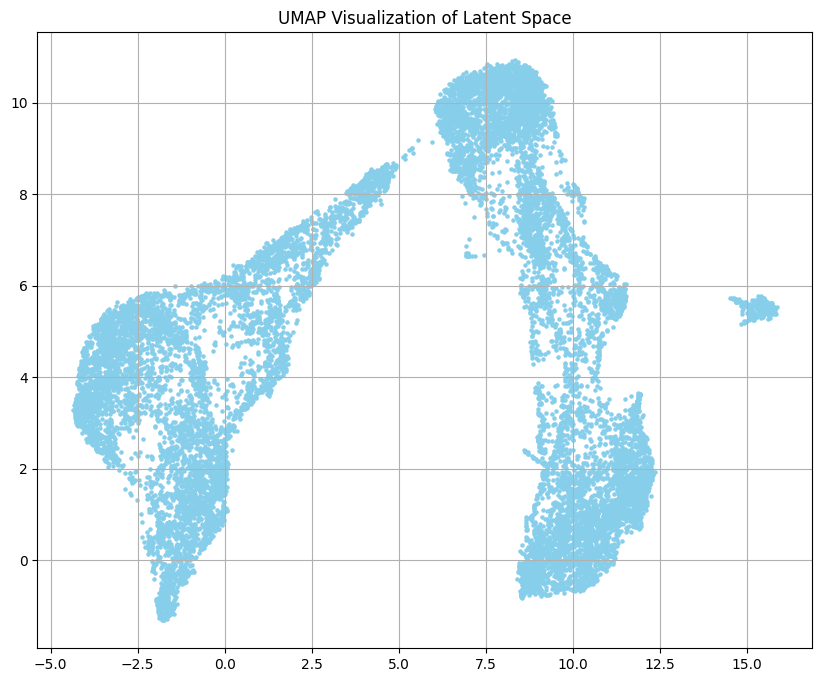

In [46]:

# latent vectors (z_mean فقط) من encoder
latent_vectors = encoder.predict(train_images)[0]  # shape: (num_images, latent_dim)

# تقليل الأبعاد
embedding = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(latent_vectors)

# رسم النتائج (لون كل نقطة حسب اسم الملف أو اللون السائد لو عندك)
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c='skyblue')
plt.title("UMAP Visualization of Latent Space")
plt.grid(True)
plt.show()
